In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

df = pd.read_csv("data/deponieanlieferungen-tufentobel.csv", delimiter=';')

#Check for missing values
missing_values = df.isna().sum()
missing_values

#missing values are in column "Kanton" with only 94 values missing
#also, the there are no relevant outliers in these 94 values
df[df['Kanton'].isna()].describe()

#drop missing values for Kanton
df.dropna(subset=['Kanton'], inplace=True)

#check where the anlieferungen are zero tons
df[df['Gewicht in Tonnen'] == 0].value_counts().sum()

#remove these values
df.drop(df[df['Gewicht in Tonnen'] == 0].index, inplace=True)

#test if it worked
df[df['Gewicht in Tonnen'] == 0].value_counts().sum()

#check very small values
#print(df[df['Gewicht in Tonnen'] < 0.1].value_counts().sum())

#check duplicates
duplicates = df.duplicated()
#print(f"Number of duplicate rows: {duplicates.sum()}")

# #Visualize the outliers in a plot
# plt.figure(figsize=(10, 6))
# plt.boxplot(df['Gewicht in Tonnen'], vert=False)
# plt.title('Boxplot of Gewicht in Tonnen')
# plt.xlabel('Gewicht in Tonnen')
# plt.show()


# df[df['Gewicht in Tonnen'] > 35]

#there is one outlier with 56.7 tons, the other values dont go over 35 tons
#remove this outlier
df.drop(df[df['Gewicht in Tonnen'] > 50].index, inplace=True)

#Time series decomposition

# Convert the date column to datetime
df['Anlieferungsdatum'] = pd.to_datetime(df['Anlieferungsdatum'], utc=True)

# # Set the date column as the index
# df.set_index('Anlieferungsdatum', inplace=True)

In [85]:
df = df[["Anlieferungsdatum", "Material", "Gewicht in Tonnen"]]

In [86]:
df = df[df["Material"] == "Sauberer Aushub"]
df = df.drop(columns=["Material"])
df = df.resample('D', on='Anlieferungsdatum').sum()

In [87]:
# Resample the data to daily frequency
daily_data = df['Gewicht in Tonnen'].resample('D').sum()
daily_data

Anlieferungsdatum
2019-02-07 00:00:00+00:00      18.18
2019-02-08 00:00:00+00:00       0.00
2019-02-09 00:00:00+00:00       0.00
2019-02-10 00:00:00+00:00       0.00
2019-02-11 00:00:00+00:00       0.00
                              ...   
2024-02-24 00:00:00+00:00       0.00
2024-02-25 00:00:00+00:00       0.00
2024-02-26 00:00:00+00:00    1805.62
2024-02-27 00:00:00+00:00    1157.26
2024-02-28 00:00:00+00:00     535.36
Freq: D, Name: Gewicht in Tonnen, Length: 1848, dtype: float64

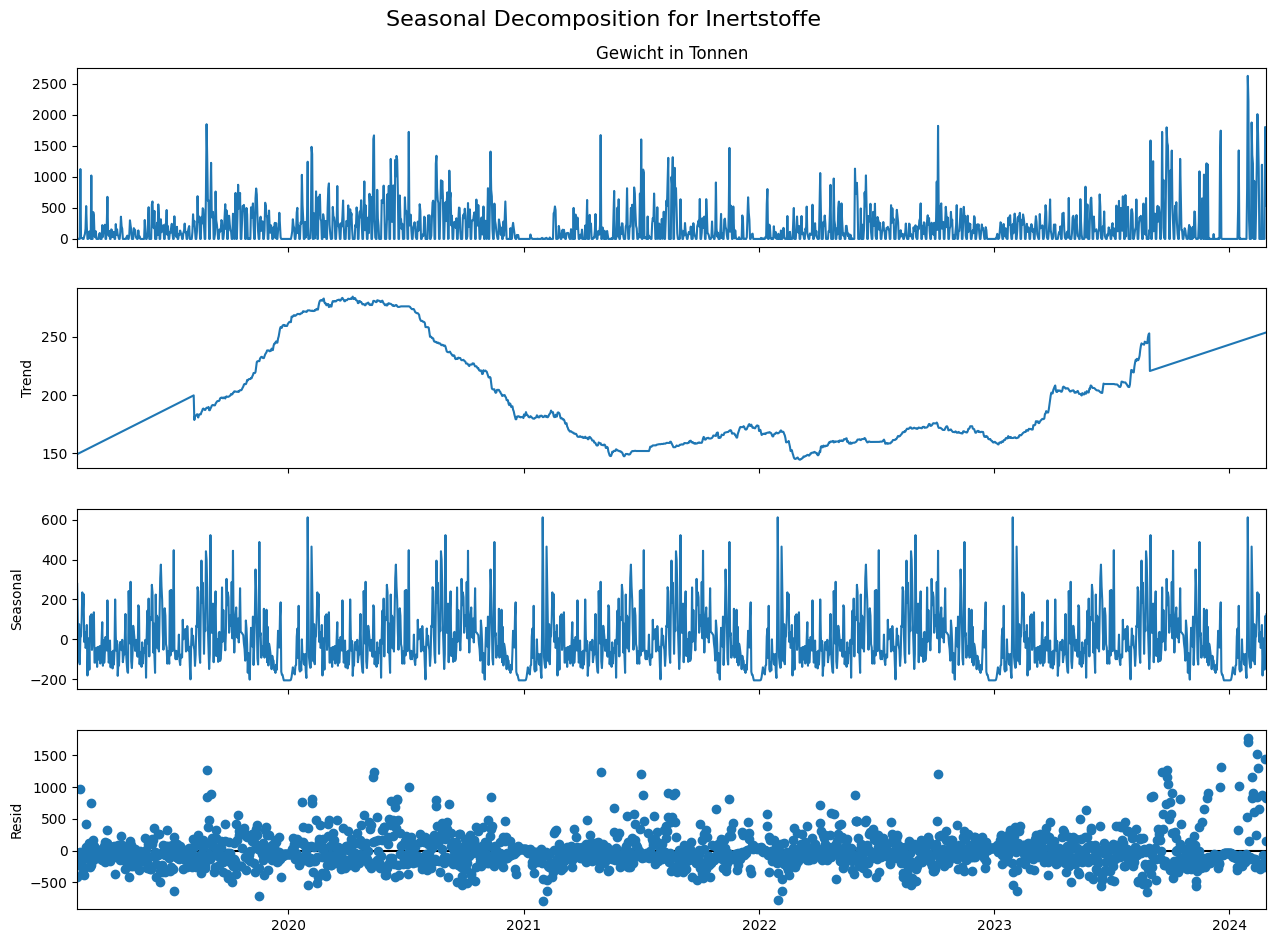

In [88]:

# Perform seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(daily_data, model='additive', period=365, extrapolate_trend='freq')

# Plot the decomposition
# Extract trend and seasonal components
trend = decomposition.trend
seasonal = decomposition.seasonal

# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(14, 10)
fig.suptitle('Seasonal Decomposition for Inertstoffe', fontsize=16)
plt.show()

Decomposition

In [89]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(daily_data)

# Extract and print the test statistic and p-value
adf_statistic = adf_result[0]
p_value = adf_result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')
print("Critical Values:", adf_result[4])

ADF Statistic: -5.989506231238724
p-value: 1.759354297613577e-07
Critical Values: {'1%': np.float64(-3.4339382310452033), '5%': np.float64(-2.863125003847544), '10%': np.float64(-2.56761380228936)}


The ADF Statistic 
−
6.1059
−6.1059 is more negative than the critical values at all levels (1%, 5%, 10%).
The p-value is much smaller than 
0.05
0.05, providing strong evidence to reject the null hypothesis.
Conclusion:
The time series is stationary at all commonly used significance levels.

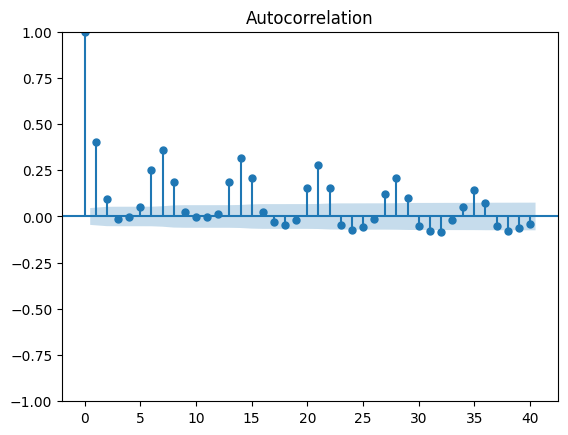

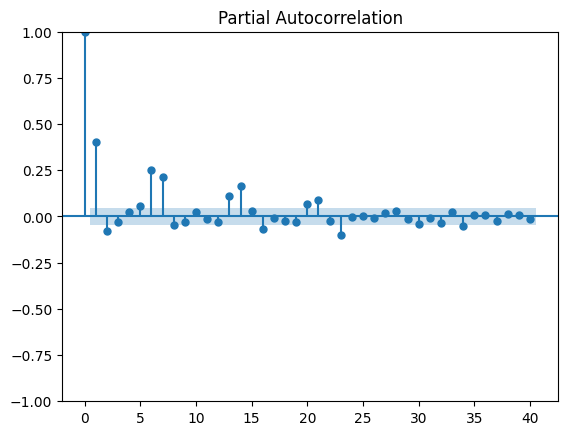

In [90]:

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF
plot_acf(daily_data, lags=40)
plot_pacf(daily_data, lags=40)
plt.show()


Iteration 1, Forecasting Error (MSE): 20121.5292
Iteration 2, Forecasting Error (MSE): 40574.6313
Iteration 3, Forecasting Error (MSE): 58130.3179
Iteration 4, Forecasting Error (MSE): 161187.0984
Iteration 5, Forecasting Error (MSE): 257814.3108


/Users/carlernstmueller/.pyenv/versions/project_13/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


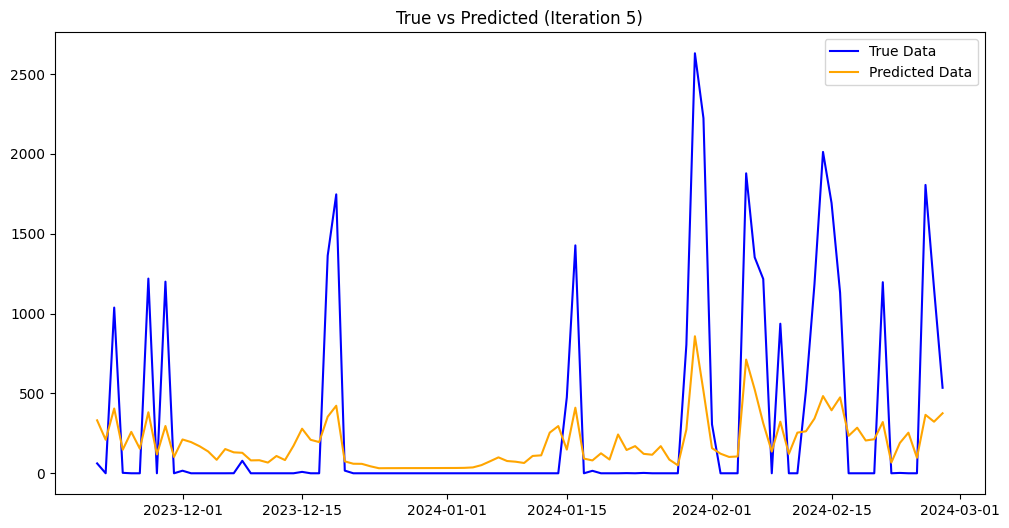


Average Forecasting Error (MSE): 107565.5775


In [92]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

# --- 1. Daten laden ---
# already loaded

# --- 2. Saisonalität und Trend extrahieren ---
# Additive Dekomposition
# decomposition = sm.tsa.seasonal_decompose(daily_data, model='additive', period=365, extrapolate_trend='freq')
# trend = decomposition.trend
# seasonal = decomposition.seasonal

# --- 3. ARIMA-Parameter ---
p, d, q = 1, 1, 1

# --- 4. Rolling Cross-Validation ---
n_splits = 5
test_size = 100
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
errors = []

# Rolling Cross-Validation Loop
for i, (train_index, test_index) in enumerate(tscv.split(daily_data)):
    # Split train and test sets
    train, test = daily_data.iloc[train_index], daily_data.iloc[test_index]
    
    # Extract trend and seasonality for train/test sets
    trend_train, trend_test = trend.iloc[train_index], trend.iloc[test_index]
    seasonal_train, seasonal_test = seasonal.iloc[train_index], seasonal.iloc[test_index]
    
    # Detrend and deseasonalize the training data
    train_residual = train - trend_train - seasonal_train
    
    # Standardize the detrended training data
    train_mean, train_std = train_residual.mean(), train_residual.std()
    train_standardized = (train_residual - train_mean) / train_std
    
    # Standardize the test set based on training statistics
    test_residual = test - trend_test - seasonal_test
    test_standardized = (test_residual - train_mean) / train_std

    # Fit ARIMA model on the standardized residuals
    model = ARIMA(train_standardized, order=(p, d, q))
    model_fit = model.fit()
    
    # Forecast standardized residuals for the test period
    forecast_standardized = model_fit.forecast(steps=len(test_standardized))
    
    # Revert standardization
    forecast_residual = forecast_standardized * train_std + train_mean
    
    # Re-add trend and seasonal components to get final predictions
    final_forecast = forecast_residual + trend_test + seasonal_test
    
    # Calculate mean squared error (MSE)
    forecast_error = mean_squared_error(test, final_forecast)
    errors.append(forecast_error)
    
    # Print MSE for this iteration
    print(f"Iteration {i+1}, Forecasting Error (MSE): {forecast_error:.4f}")
    
    # Plot actual vs predicted for the last iteration
    if i == n_splits - 1:  # Plot for the final fold
        plt.figure(figsize=(12, 6))
        plt.plot(test.index, test, label='True Data', color='blue')
        plt.plot(test.index, final_forecast, label='Predicted Data', color='orange')
        plt.title(f"True vs Predicted (Iteration {i+1})")
        plt.legend()
        plt.show()

# --- 5. Finale Zusammenfassung ---
print(f"\nAverage Forecasting Error (MSE): {np.mean(errors):.4f}")